In [1]:
import pandas as pd
import numpy as np

import pickle

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk

%matplotlib inline


## Load data

In [26]:
wine = pd.read_csv('data/wine_set_with_scent_notes_and_description.csv')

### Change type from int to object

In [21]:
wine_columns_list = list(wine.columns)
scent_columns_list = wine_columns_list[13:32]
scent_columns_list

['floral',
 'citrus',
 'tree_fruit',
 'tropical_fruit',
 'red_fruit',
 'black_fruit',
 'dried_fruit',
 'spice',
 'vegetable',
 'earth',
 'aging']

In [22]:
for name in scent_columns_list:
    wine[name] = wine[name].astype(dtype='object')
    
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68535 entries, 0 to 68534
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   country           68535 non-null  object
 1   description       68535 non-null  object
 2   designation       68535 non-null  object
 3   points            68535 non-null  int64 
 4   price_in_usd      68535 non-null  int64 
 5   province          68535 non-null  object
 6   region            68535 non-null  object
 7   wine_name         68535 non-null  object
 8   variety           68535 non-null  object
 9   winery            68535 non-null  object
 10  price_category    68535 non-null  object
 11  rating            68535 non-null  object
 12  full_description  68535 non-null  object
 13  floral            68535 non-null  object
 14  citrus            68535 non-null  object
 15  tree_fruit        68535 non-null  object
 16  tropical_fruit    68535 non-null  object
 17  red_fruit   

## K-Modes Clustering

In K-Modes Clustering the algorithm randomly assumes an initial cluster value, one by one each of the rows are selected and compared with the cluster centroids. Based on the calculated distance each row will be assigned to any of the clusters, then centroid will be reshaped based on the mode for each feature. 

We decided to cluster only on the scent columns, because this was the main idea behind the wine recommender. Adding other columns like price, variety, province or region didn't help, it only made the clusters more random. 

First we started clustering on the dataset with less detailed scent profiles. We used K-Modes and tried different initialization methods (Cao, Huang and random) from which Cao turned out to be the most detailed and accurate. We also changed the number of iterations, with less columns it made more sense to keep less iterations, we tried different numbers betwen 20 and 100, ended up with 50 giving the best result. Of course we also tested different numbers of clusters, checked which one had the best distribution and accuracy.

In [16]:
from kmodes.kmodes import KModes

km = KModes(random_state=123)

### Function to apply K-Modes and easily changing parameters

In [133]:
def k_modes_function(df, list_of_columns_to_drop, this_n_clusters = 8, this_max_iter = 100, 
                     this_init = 'Cao', this_n_init = 1, this_random_state = 123):
    
    
    scents = df.drop(columns=list_of_columns_to_drop)
    
    km = KModes(n_clusters = this_n_clusters, max_iter = this_max_iter, 
                init = this_init, n_init = this_n_init, random_state = this_random_state)
    
    km.fit(scents)
    
    labels = km.labels_
    
    df["cluster"] = labels
    
    return df

In [132]:
list_of_columns_to_drop = ['country', 'description', 'designation', 'points',
       'price_in_usd', 'province', 'region', 'wine_name', 'variety', 'winery',
       'price_category', 'rating','full_description']

In [37]:
scents = wine.drop(columns=['country', 'description', 'designation', 'points',
       'price_in_usd', 'province', 'region', 'wine_name', 'variety', 'winery',
       'price_category', 'rating','full_description'])

### Cost function used to determine the best number of clusters

In [ ]:
# running it on a dataset with almost 70000 observations takes a very long time!!! 

cost = []

for num_clusters in list(range(4,12)):

    kmode = KModes(n_clusters=num_clusters, init = "Huang", max_iter = 50, n_init = 2, verbose=1,random_state=123)

    kmode.fit_predict(scents)

    cost.append(kmode.cost_)

y = np.array([i for i in range(4,12,1)])

plt.plot(y,cost)

### K-Modes - Cao

In [139]:
value_test = k_modes_function(wine, list_of_columns_to_drop, this_n_clusters=11, this_max_iter=100,this_n_init=2)

In [140]:
value_test.cluster.value_counts()

0     22524
2      9302
7      6726
6      6337
3      6150
4      5429
1      4441
5      3927
10     1674
8      1103
9       922
Name: cluster, dtype: int64

In [141]:
feature_mode_by_cluster = value_test.groupby('cluster')[scents.columns].agg(pd.Series.mode)
feature_mode_by_cluster

,floral,citrus,tree_fruit,tropical_fruit,red_fruit,black_fruit,dried_fruit,spice,vegetable,earth,aging
cluster,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,1,0,0,1
2,0,0,0,0,1,0,0,1,0,0,1
3,0,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1,0
5,0,1,1,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,0
7,0,1,1,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,1,0,1,0


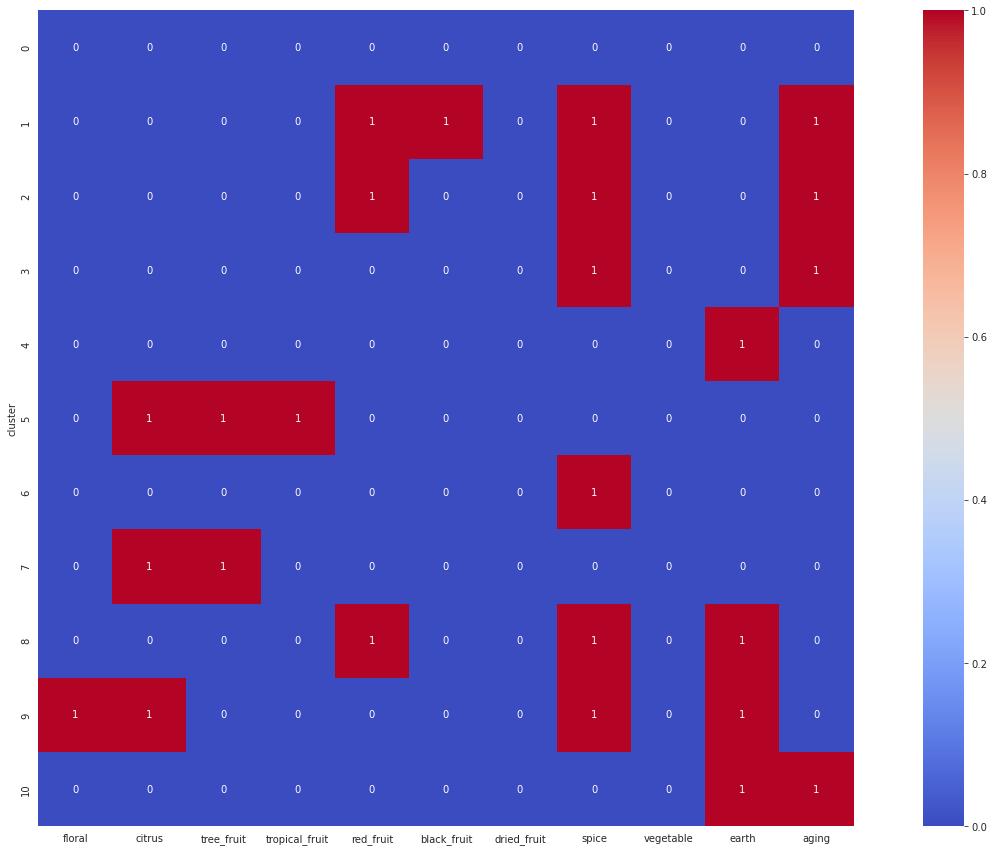

In [142]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 15))
    ax = sns.heatmap(feature_mode_by_cluster, cmap='coolwarm', vmin=0, vmax=1, annot=True, square=True)

In [143]:
#value_test.to_csv("data/cao_100_iter_11_clusters.csv", index=False)

In [630]:
value_test[value_test['cluster'] == 6].sample()

,country,description,designation,points,price_in_usd,province,region,wine_name,variety,winery,...,tree_fruit,tropical_fruit,red_fruit,black_fruit,dried_fruit,spice,vegetable,earth,aging,cluster
15382,us,"['soft', 'merlot', 'baked', 'plum', 'ripe', 'f...",estate,86,24,california,santa clara valley,jason-stephens 2009 estate merlot (santa clara...,merlot,jason-stephens,...,1,0,0,0,0,1,0,0,0,6


### K-Modes - Huang

In [118]:
value_test_huang = k_modes_function(wine, this_n_clusters=11, this_max_iter=50,this_init = 'Huang',this_n_init=2)

In [119]:
value_test_huang.cluster.value_counts()

4     10318
6      9223
10     8983
3      7395
1      7274
0      6644
2      6483
7      5461
8      3899
5      2095
9       760
Name: cluster, dtype: int64

In [120]:
feature_mode_by_cluster_huang = value_test_huang.groupby('cluster')[scents.columns].agg(pd.Series.mode)
feature_mode_by_cluster_huang

,floral,citrus,tree_fruit,tropical_fruit,red_fruit,black_fruit,dried_fruit,spice,vegetable,earth,aging
cluster,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,1,0,0,0,0,0,0,0
6,0,1,1,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,1


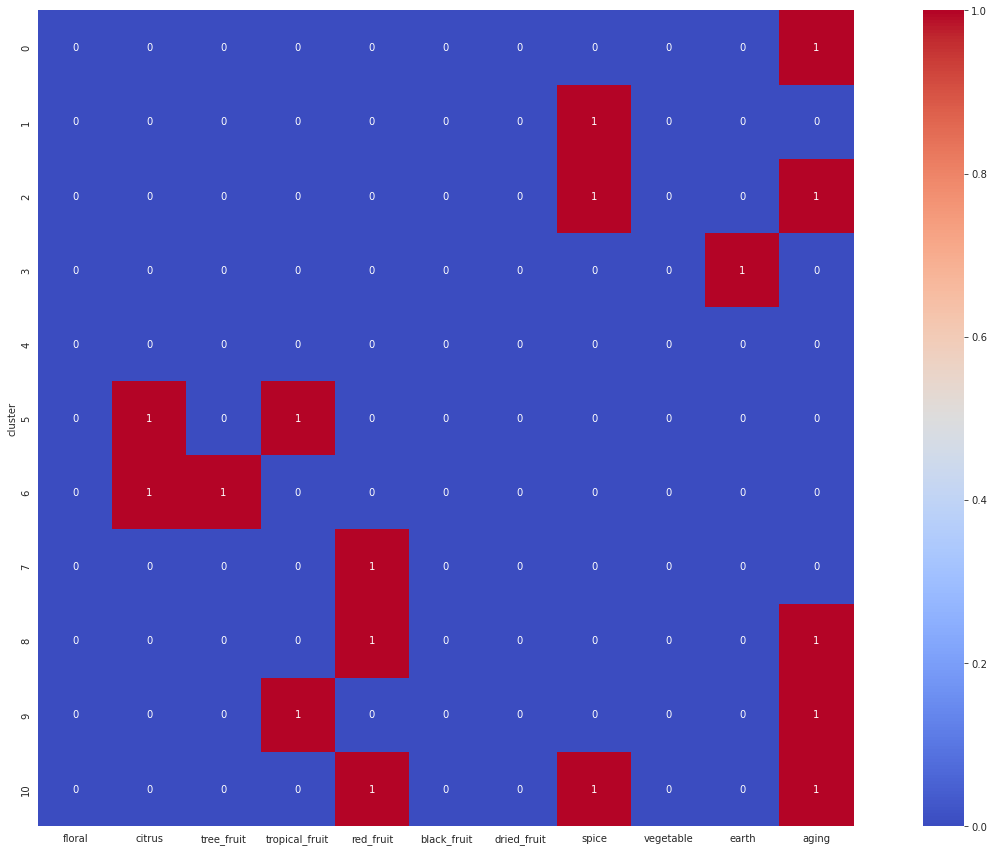

In [121]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 15))
    ax = sns.heatmap(feature_mode_by_cluster_huang, cmap='coolwarm', vmin=0, vmax=1, annot=True, square=True)

In [126]:
#value_test_huang.to_csv('data/huang_50_iter_11_clusters.csv', index=False)

### K-Modes - random

In [109]:
value_test_random = k_modes_function(wine, this_n_clusters=11, this_max_iter=50,this_init = 'random',this_n_init=2)

In [110]:
value_test_random.cluster.value_counts()

10    10318
4      9210
5      9187
1      7133
3      6695
9      5982
7      5461
2      4739
6      3899
0      3834
8      2077
Name: cluster, dtype: int64

In [111]:
feature_mode_by_cluster_random = value_test_random.groupby('cluster')[scents.columns].agg(pd.Series.mode)
feature_mode_by_cluster_random

,floral,citrus,tree_fruit,tropical_fruit,red_fruit,black_fruit,dried_fruit,spice,vegetable,earth,aging
cluster,,,,,,,,,,,
0,0,0,0,0,0,1,0,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,1,0
4,0,1,1,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,1,0,0,1
6,0,0,0,0,1,0,0,0,0,0,1
7,0,0,0,0,1,0,0,0,0,0,0
8,0,1,0,1,0,0,0,0,0,0,0


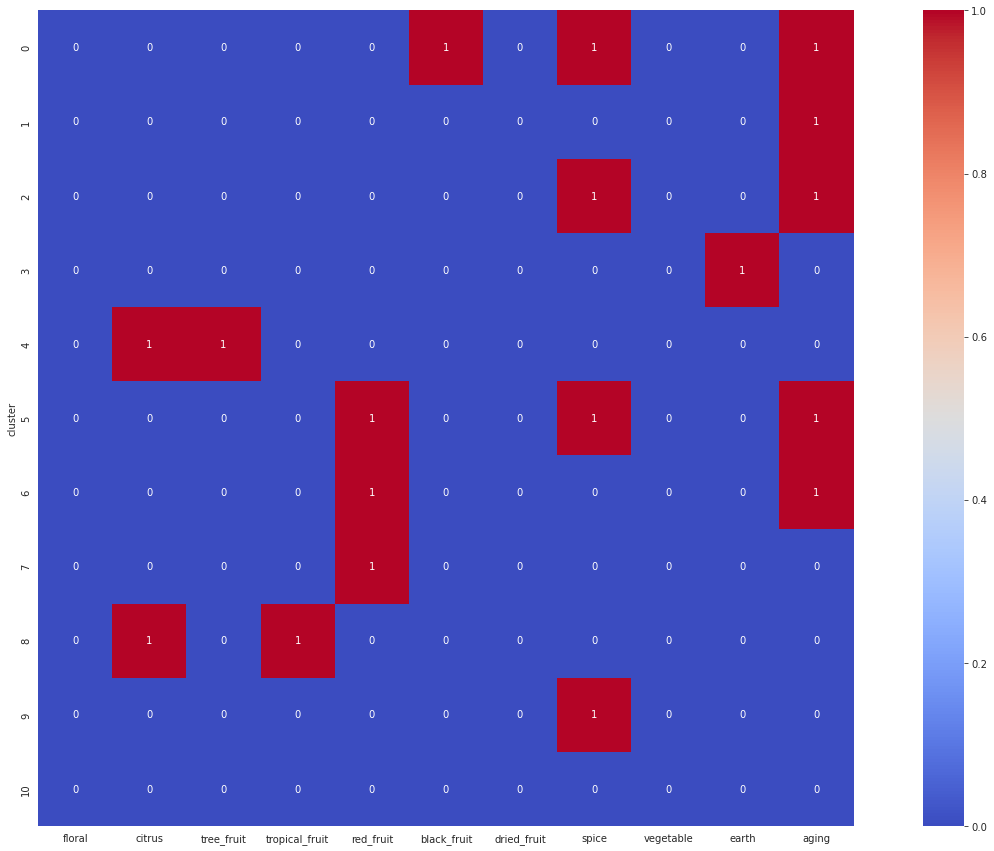

In [112]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 15))
    ax = sns.heatmap(feature_mode_by_cluster_random, cmap='coolwarm', vmin=0, vmax=1, annot=True, square=True)

## More detailed scent profiles dataset

To check if the flavor profiles will be more accurate we decided to run another trial with our more detailed dataset - the flavors in it are divided into more smaller categories. We ended up using this version for our recommender. 

With more flavor profiles it makes more sense to iterate more times - our chosen dataset used parameters n_clusters = 12, init = 'Cao', max_iter = 100, n_iter = 2

In [127]:
wine2 = pd.read_csv('data/detailed_wine_set_with_scent_notes.csv')

In [129]:
wine2_columns_list = list(wine2.columns)
scent2_columns_list = wine2_columns_list[13:]
scent2_columns_list

['floral',
 'citrus',
 'tree_fruit',
 'tropical_fruit',
 'red_fruit',
 'black_fruit',
 'dried_fruit',
 'noble_rot',
 'herbal',
 'spice',
 'vegetable',
 'nut',
 'earth',
 'microbial',
 'sauvage',
 'aldehyde',
 'fumee',
 'wood']

In [130]:
for name in scent2_columns_list:
    wine2[name] = wine2[name].astype(dtype='object')
    
wine2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68535 entries, 0 to 68534
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   country           68535 non-null  object
 1   description       68535 non-null  object
 2   designation       68535 non-null  object
 3   points            68535 non-null  int64 
 4   price_in_usd      68535 non-null  int64 
 5   province          68535 non-null  object
 6   region            68535 non-null  object
 7   wine_name         68535 non-null  object
 8   variety           68535 non-null  object
 9   winery            68535 non-null  object
 10  price_category    68535 non-null  object
 11  rating            68535 non-null  object
 12  full_description  68535 non-null  object
 13  floral            68535 non-null  object
 14  citrus            68535 non-null  object
 15  tree_fruit        68535 non-null  object
 16  tropical_fruit    68535 non-null  object
 17  red_fruit   

In [162]:
scents2 = wine2.drop(columns=['country', 'description', 'designation', 'points',
       'price_in_usd', 'province', 'region', 'wine_name', 'variety', 'winery',
       'price_category', 'rating','full_description'])

### K-Modes - Cao

For determining the number of clusters we again used the cost function, this time also with different max iterations - this didn't make such a big difference though. 

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/50, moves: 3439, cost: 181630.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/50, moves: 6585, cost: 171193.0
Run 1, iteration: 2/50, moves: 1, cost: 171193.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/50, moves: 7071, cost: 169898.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/50, moves: 9264, cost: 158625.0
Run 1, iteration: 2/50, moves: 3134, cost: 156766.0
Run 1, iteration: 3/50, moves: 0, cost: 156766.0
Initialization met

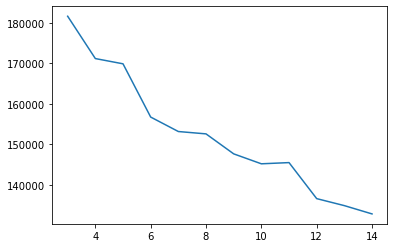

In [195]:
cost_cao_det = []

for num_clusters in list(range(3,15)):

    kmode = KModes(n_clusters=num_clusters, init = "Cao", max_iter = 50, n_init = 2, verbose=1,random_state=123)

    kmode.fit_predict(scents2)

    cost_cao_det.append(kmode.cost_)

y = np.array([i for i in range(3,15,1)])

plt.plot(y,cost_cao_det)

In [197]:
wine_cao_50 = k_modes_function(wine2, list_of_columns_to_drop, this_n_clusters=12, this_max_iter=50,this_n_init=2)

In [198]:
wine_cao_50.cluster.value_counts()

0     26216
11    10692
7      9667
3      4665
10     3976
6      3539
5      2687
4      2368
2      1964
1      1271
8      1047
9       443
Name: cluster, dtype: int64

In [199]:
feature_mode_by_cluster_cao_50 = wine_cao_50.groupby('cluster')[scents2.columns].agg(pd.Series.mode)
feature_mode_by_cluster_cao_50

,floral,citrus,tree_fruit,tropical_fruit,red_fruit,black_fruit,dried_fruit,noble_rot,herbal,spice,vegetable,nut,earth,microbial,sauvage,aldehyde,fumee,wood,cluster
cluster,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,1,1
2,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,2
3,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,3
4,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,4
5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
6,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,6
7,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
8,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,8


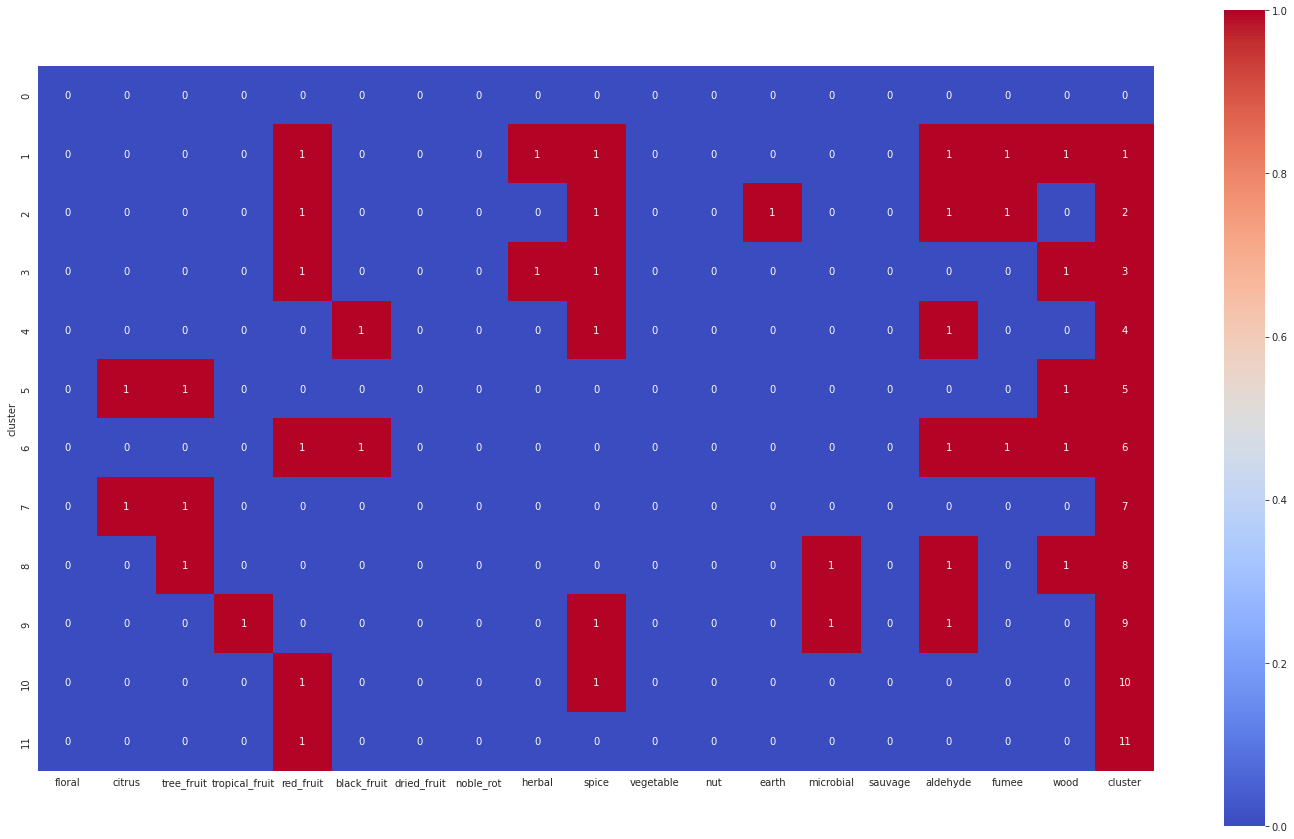

In [200]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 15))
    ax = sns.heatmap(feature_mode_by_cluster_cao_50, cmap='coolwarm', vmin=0, vmax=1, annot=True, square=True)

In [338]:
#wine_cao_50.to_csv("data/det_cao_50_iter_12_clusters.csv", index=False)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3439, cost: 181630.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6585, cost: 171193.0
Run 1, iteration: 2/100, moves: 1, cost: 171193.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7071, cost: 169898.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9264, cost: 158625.0
Run 1, iteration: 2/100, moves: 3134, cost: 156766.0
Run 1, iteration: 3/100, moves: 0, cost: 156766.0
Initializat

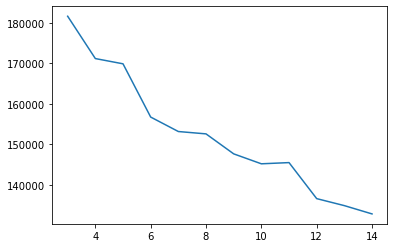

In [196]:
cost_cao_det_100 = []

for num_clusters in list(range(3,15)):

    kmode = KModes(n_clusters=num_clusters, init = "Cao", max_iter = 100, n_init = 2, verbose=1,random_state=123)

    kmode.fit_predict(scents2)

    cost_cao_det_100.append(kmode.cost_)

y = np.array([i for i in range(3,15,1)])

plt.plot(y,cost_cao_det_100)

In [201]:
wine_cao_100 = k_modes_function(wine2, list_of_columns_to_drop, this_n_clusters=12, this_max_iter=100,this_n_init=2)

In [202]:
wine_cao_100.cluster.value_counts()

0     35041
5     10728
6      3982
3      3748
8      3224
7      2583
9      2375
2      2026
1      1283
11     1277
10     1152
4      1116
Name: cluster, dtype: int64

In [957]:
scents_new = scents2.drop(columns='cluster')
scents_new

In [936]:
feature_mode_by_cluster_cao_100_new = wine_cao_100.groupby('cluster')[scents_new.columns].agg(pd.Series.mode)
feature_mode_by_cluster_cao_100_new

,floral,citrus,tree_fruit,tropical_fruit,red_fruit,black_fruit,dried_fruit,noble_rot,herbal,spice,vegetable,nut,earth,microbial,sauvage,aldehyde,fumee,wood
cluster,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,1
2,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0
3,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1
5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0
8,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


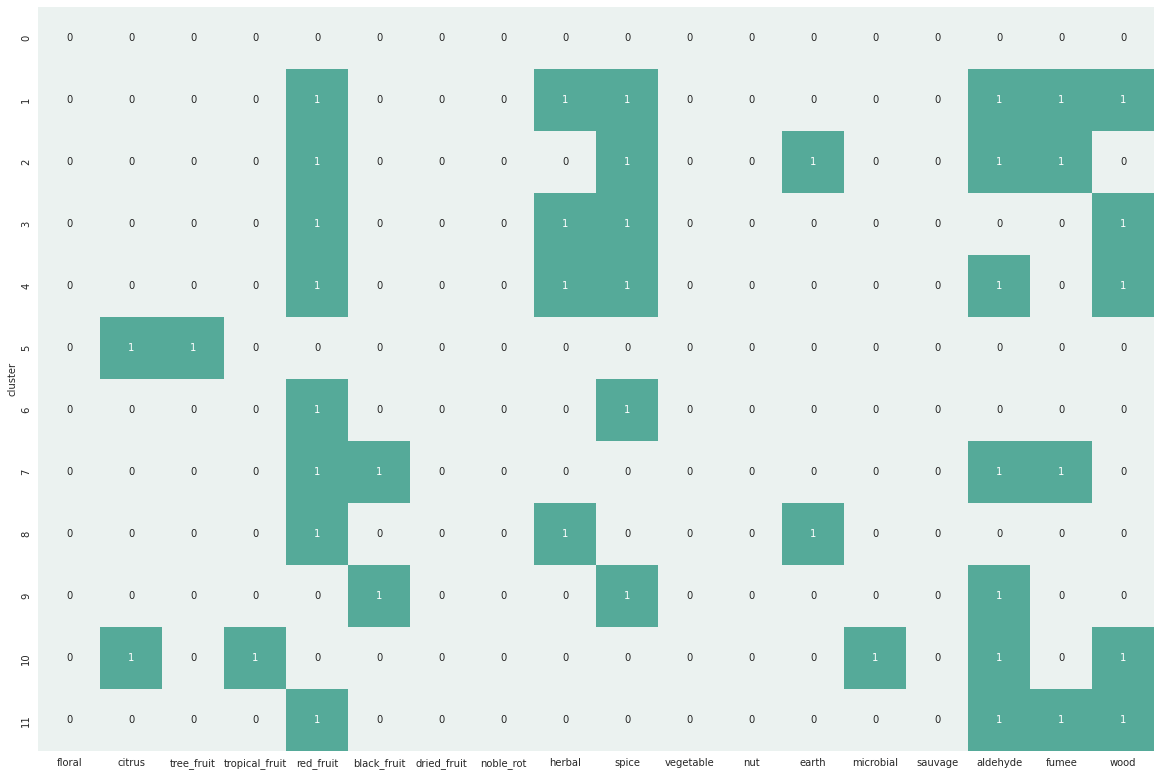

In [955]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20,15))
    my_colors = sns.color_palette("light:#5A9", as_cmap=True)
    ax = sns.heatmap(feature_mode_by_cluster_cao_100_new, cmap=my_colors, vmin=0, vmax=1, annot=True, square=True, cbar=False)

In [994]:
wine_cao_100[wine_cao_100['cluster'] == 11].sample()

,country,description,designation,points,price_in_usd,province,region,wine_name,variety,winery,...,spice,vegetable,nut,earth,microbial,sauvage,aldehyde,fumee,wood,cluster
51365,spain,"['tobacco', 'mild', 'raisin', 'dry', 'oak', 's...",ursa maior crianza,86,10,northern spain,rioja,bodegas ondarre 2007 ursa maior crianza (rioja),tempranillo blend,bodegas ondarre,...,0,0,0,0,0,0,0,1,1,11


In [835]:
#wine_cao_100.to_csv("data/det_cao_100_iter_12_clusters.csv", index=False)

### K-Modes - Huang 

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/50, moves: 25375, cost: 150267.0
Run 1, iteration: 2/50, moves: 10374, cost: 150267.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/50, moves: 6870, cost: 148955.0
Run 2, iteration: 2/50, moves: 2773, cost: 148955.0
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/50, moves: 7564, cost: 133755.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/50, moves: 8674, cost: 148648.0
Run 2, iteration: 2/50, moves: 2698, cost: 148572.0
Run 2, iteration: 3/50, moves: 0, cost: 148572.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/50, moves: 13477, cost: 121143.0
Run 1, iteration: 2/50, moves: 7553, cost: 115019.0
Run 1, iteration: 3/50, moves: 5138,

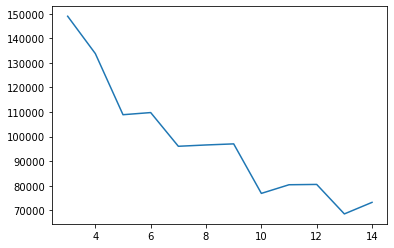

In [148]:
cost_huang_det = []

for num_clusters in list(range(3,15)):

    kmode = KModes(n_clusters=num_clusters, init = "Huang", max_iter = 50, n_init = 2, verbose=1,random_state=123)

    kmode.fit_predict(scents2)

    cost_huang_det.append(kmode.cost_)

y = np.array([i for i in range(3,15,1)])

plt.plot(y,cost_huang_det)

In [171]:
wine_huang_50 = k_modes_function(wine2, list_of_columns_to_drop, this_n_clusters=10, this_max_iter=50,this_init='Huang',this_n_init=2)

In [172]:
wine_huang_50.cluster.value_counts()

5    19721
0    13069
4     9564
1     8127
6     5068
2     4669
3     3782
7     2896
8      878
9      761
Name: cluster, dtype: int64

In [173]:
feature_mode_by_cluster_huang_50 = wine_huang_50.groupby('cluster')[scents2.columns].agg(pd.Series.mode)
feature_mode_by_cluster_huang_50

,floral,citrus,tree_fruit,tropical_fruit,red_fruit,black_fruit,dried_fruit,noble_rot,herbal,spice,vegetable,nut,earth,microbial,sauvage,aldehyde,fumee,wood,cluster
cluster,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,2
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,3
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,6
7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7
8,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,8


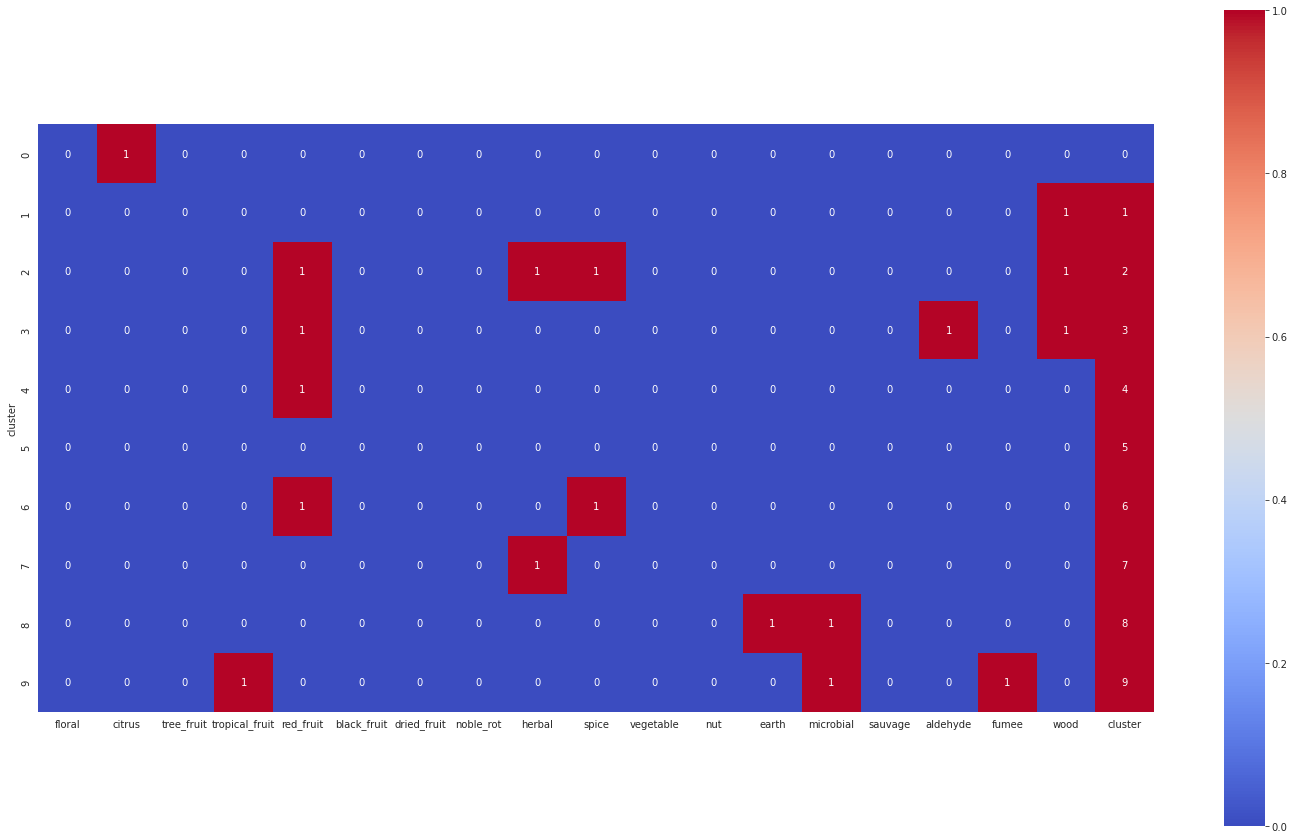

In [174]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 15))
    ax = sns.heatmap(feature_mode_by_cluster_huang_50, cmap='coolwarm', vmin=0, vmax=1, annot=True, square=True)

In [193]:
wine_huang_50[value_test['cluster'] == 0].sample()

,country,description,designation,points,price_in_usd,province,region,wine_name,variety,winery,...,spice,vegetable,nut,earth,microbial,sauvage,aldehyde,fumee,wood,cluster
13577,us,"['juicy', 'high', 'acidity', 'easy', 'quaffer'...",estate grown,90,35,california,dry creek valley,mounts 2015 estate grown picpoul (dry creek va...,picpoul,mounts,...,0,0,0,0,0,0,0,0,0,3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 25375, cost: 150267.0
Run 1, iteration: 2/100, moves: 10374, cost: 150267.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6870, cost: 148955.0
Run 2, iteration: 2/100, moves: 2773, cost: 148955.0
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7564, cost: 133755.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8674, cost: 148648.0
Run 2, iteration: 2/100, moves: 2698, cost: 148572.0
Run 2, iteration: 3/100, moves: 0, cost: 148572.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 13477, cost: 121143.0
Run 1, iteration: 2/100, moves: 7553, cost: 115019.0
Run 1, iteration: 3/100, m

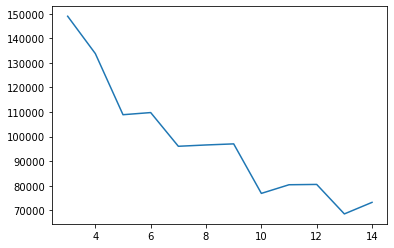

In [149]:
cost_huang_det_100 = []

for num_clusters in list(range(3,15)):

    kmode = KModes(n_clusters=num_clusters, init = "Huang", max_iter = 100, n_init = 2, verbose=1,random_state=123)

    kmode.fit_predict(scents2)

    cost_huang_det_100.append(kmode.cost_)

y = np.array([i for i in range(3,15,1)])

plt.plot(y,cost_huang_det_100)

In [175]:
wine_huang_100 = k_modes_function(wine2, list_of_columns_to_drop, this_n_clusters=10, this_max_iter=100,this_init='Huang',this_n_init=2)

In [176]:
wine_huang_100.cluster.value_counts()

3    18785
2    11755
0     9944
9     8631
6     7414
1     3987
4     2987
7     2306
5     1665
8     1061
Name: cluster, dtype: int64

In [177]:
feature_mode_by_cluster_huang_100 = wine_huang_100.groupby('cluster')[scents2.columns].agg(pd.Series.mode)
feature_mode_by_cluster_huang_100

,floral,citrus,tree_fruit,tropical_fruit,red_fruit,black_fruit,dried_fruit,noble_rot,herbal,spice,vegetable,nut,earth,microbial,sauvage,aldehyde,fumee,wood,cluster
cluster,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4
5,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,5
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6
7,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7
8,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,8


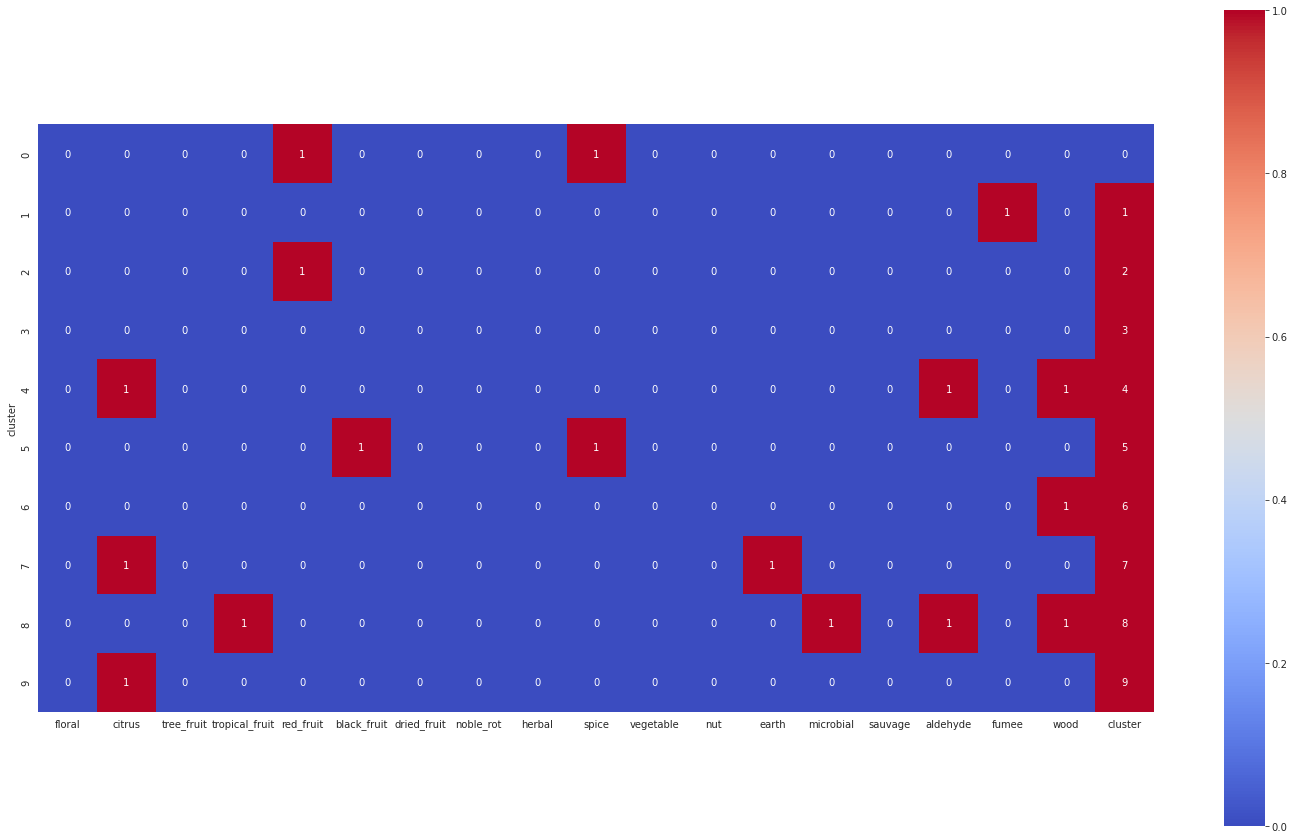

In [178]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 15))
    ax = sns.heatmap(feature_mode_by_cluster_huang_100, cmap='coolwarm', vmin=0, vmax=1, annot=True, square=True)